In [2]:
import numpy as np
from tqdm import tqdm
from nuance.utils import transit
import tinygp
import matplotlib.pyplot as plt
import jax
jax.config.update("jax_enable_x64", True)
from pathlib import Path
import glob
import yaml
import sys
sys.path.append("./lib")
sys.path.append("../lib")
from utils import white_red
from wotan import flatten

n = 10000
np.random.seed(42)
tau_v = np.random.uniform(0.1, 20, size=n)
delta_v = np.random.uniform(0.1, 10, size=n)

/Users/lgrcia/code/nuance/nuance/nuance.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
# simulate transit
dur = 0.04
time = np.linspace(0, dur*50, 2000)
depth = 0.8e-2
t0 = time.mean()
n_tr = dur/np.median(np.diff(time))
signal = transit(time, t0, dur, depth, c=10)

# white noise
wsigma = 5e-4

In [5]:
time.mean()

0.9999999999999998

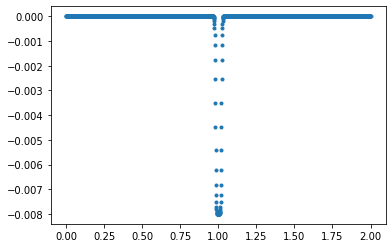

In [102]:
plt.plot(time, signal, ".")

In [103]:
def gp_sample(params):   
    kernel = tinygp.kernels.quasisep.SHO(params['omega'], params['quality'], sigma=params["sigma"])
    gp = tinygp.GaussianProcess(kernel, time, diag=params['error']**2)
    return gp.sample(jax.random.PRNGKey(params["seed"]))

In [104]:
def gp_sample(params):   
    kernel = tinygp.kernels.quasisep.SHO(params['omega'], params['quality'], sigma=params["sigma"])
    gp = tinygp.GaussianProcess(kernel, time, diag=params['error']**2)
    return gp.sample(jax.random.PRNGKey(params["seed"]))

def variability(tau_v, delta_v, seed):
    
    params = {
        "relative_duration": float(tau_v),
        "relative_depth": float(delta_v),
        "omega" : float(np.pi/(dur * tau_v)),
        "quality" : float(10),
        "sigma" : float(depth * delta_v**2 / 4),
        "depth": float(depth),
        "duration": float(dur),
        "seed": int(seed),
        "error": float(wsigma)
    }
    
    return gp_sample(params), params

In [105]:
folder = Path("../data/simu1/")
(folder/"lightcurves").mkdir(exist_ok=True, parents=True)
(folder/"params").mkdir(exist_ok=True, parents=True)

In [106]:
for i, (tau, delta) in enumerate(zip(tqdm(tau_v), delta_v)):
    flux, params = variability(tau, delta, i)
    flux += signal + 1.
    np.save(folder / f"lightcurves/{i}.npy", np.array([time, flux, np.ones_like(time)*wsigma]))
    yaml.safe_dump(params, open(folder / f"params/{i}.yaml", "w"))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [33:30<00:00,  4.97it/s]


In [107]:
lcs = glob.glob(str(folder/"lightcurves/*.npy"))
tau_v = []
delta_v = []
snrs = []

intransit = signal < -depth/2

for lc in tqdm(lcs):
    i = int(lc.split("/")[-1].strip(".npy"))
    params = yaml.full_load(open(folder / f"params/{i}.yaml", "r"))
    time, flux, error = np.load(lc)
    
    flatten_flux = flatten(time, flux, window_length=3*params["duration"], return_trend=False)
    new_depth = np.max([0, np.median(flatten_flux[~intransit]) - np.median(flatten_flux[intransit])])
    w = wsigma
    r = np.max([0, np.std(flatten_flux[~intransit])-w])
    snr = new_depth/np.sqrt((w**2)/n_tr + r**2)
    tau_v.append(params["relative_duration"])
    delta_v.append(params["relative_depth"])
    snrs.append(snr)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:02<00:00, 81.89it/s]


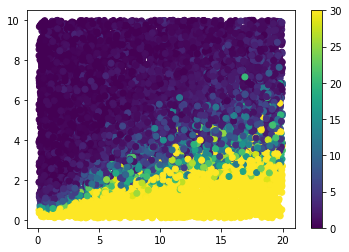

In [109]:
plt.scatter(tau_v, delta_v, c=snrs, vmax=30)
plt.colorbar()

In [111]:
import pandas as pd

df = pd.DataFrame({
    "tau_v": tau_v,
    "delta_v": delta_v,
    "snr":snrs
})

df.to_csv("../data/simu1/results.csv", index=False)

In [1]:
import numpy 
import matplotlib.pyplot as plt

import sys
sys.path.append("/Users/lgrcia/code/paper-nuance/workflows/cleaning_snr/scripts")
sys.path.append("/Users/lgrcia/code/paper-nuance/workflows/cleaning_snr/lib")

from make_lightcurve import make_lc
from make_params import make
import numpy as np

params = make(1., 1., 1.)
x, y, z = make_lc(params, params['seed'])

/Users/lgrcia/code/nuance/nuance/nuance.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
params

{'t0': 1.4,
 'duration': 0.04,
 'depth': 0.01,
 'error': 0.0005,
 'relative_duration': 1.0,
 'relative_depth': 1.0,
 'omega': 78.53981633974483,
 'quality': 84.35733813119954,
 'sigma': 0.0025,
 'seed': 1}

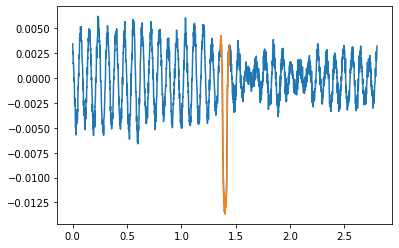

In [5]:
plt.plot(x, y)
m = np.abs(x - params['t0']) < params['duration']
plt.plot(x[m], y[m])

In [16]:
np.abs(x - params['t0']) < params['duration']

array([False, False, False, ..., False, False, False])